<a href="https://colab.research.google.com/github/alibitarafan/Sentiment-MP2/blob/main/MP2_Sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, Flatten, LSTM
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [ ]:

# Load the data
data = pd.read_csv("Sentiment140.tenPercent.sample.tweets.tsv",sep='\t')

# Pre-process the data
y = data["sentiment_label"].values
X = data["tweet_text"].values


In [ ]:
data.head()

,sentiment_label,tweet_text
0,4,"@elephantbird Hey dear, Happy Friday to You A..."
1,4,Ughhh layin downnnn Waiting for zeina to co...
2,0,"@greeniebach I reckon he'll play, even if he's..."
3,0,@vaLewee I know! Saw it on the news!
4,0,very sad that http://www.fabchannel.com/ has c...


In [ ]:
data.isnull().values.any()
data.shape

(160000, 2)

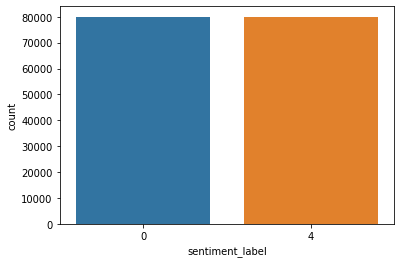

In [ ]:
import seaborn as sns

sns.countplot(x='sentiment_label', data=data)

In [ ]:
import re

def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove mentions
    sentence = re.sub(r'@[A-Za-z0-9]+', '', sentence)

    # Removing '#'
    sentence = re.sub(r"#", '', sentence)

    # Removing RT
    sentence = re.sub(r'RT[\s]+',' ' , sentence)

    # Removing hyperlinks
    sentence = re.sub(r'https?:\/\/\s+','', sentence)

    return sentence

In [ ]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [ ]:
X = []
sentences = list(data['tweet_text'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [ ]:
X[2]

" I reckon he'll play, even if he's not 100%...but i know nothing!! ;) It won't be the same without him. "

In [ ]:
y = data['sentiment_label']

In [ ]:
y = np.array(list(map(lambda x: 1 if x==4 else 0, y)))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

X_train = pad_sequences(X_train)
maxlen = X_train.shape[1]
X_test = pad_sequences(X_test, maxlen=maxlen)

print(f'X_train {X_train.shape} \nX_test {X_test.shape}')

X_train (128000, 40) 
X_test (32000, 40)


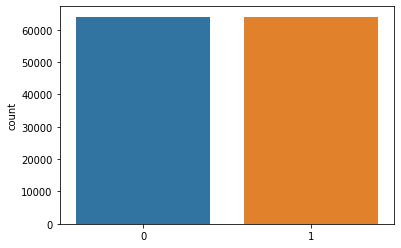

In [ ]:
sns.countplot(x=y_train, data=data)

# **CNN**

In [ ]:
# the CNN model
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=maxlen, trainable=False))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["acc"])

print(model.summary())

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 40, 100)           7341900   
                                                                 
 conv1d_16 (Conv1D)          (None, 36, 128)           64128     
                                                                 
 global_max_pooling1d_7 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_26 (Dense)            (None, 1)                 129       
                                                                 
Total params: 7,406,157
Trainable params: 64,257
Non-trainable params: 7,341,900
_________________________________________________________________
None


In [ ]:
print(vocab_size)

73419


In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=6, batch_size=128, validation_split=0.2)


Epoch 1/6
800/800 [==============================] - 25s 31ms/step - loss: 0.6194 - acc: 0.6528 - val_loss: 0.5770 - val_acc: 0.6968
Epoch 2/6
800/800 [==============================] - 24s 30ms/step - loss: 0.5507 - acc: 0.7180 - val_loss: 0.5452 - val_acc: 0.7236
Epoch 3/6
800/800 [==============================] - 25s 31ms/step - loss: 0.5143 - acc: 0.7469 - val_loss: 0.5290 - val_acc: 0.7354
Epoch 4/6
800/800 [==============================] - 24s 30ms/step - loss: 0.4863 - acc: 0.7675 - val_loss: 0.5215 - val_acc: 0.7403
Epoch 5/6
800/800 [==============================] - 24s 30ms/step - loss: 0.4628 - acc: 0.7833 - val_loss: 0.5144 - val_acc: 0.7450
Epoch 6/6
800/800 [==============================] - 24s 29ms/step - loss: 0.4414 - acc: 0.7993 - val_loss: 0.5222 - val_acc: 0.7401


In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)

1000/1000 [==============================] - 5s 5ms/step - loss: 0.5182 - acc: 0.7411


In [ ]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.5181964039802551
Test Accuracy: 0.7410625219345093


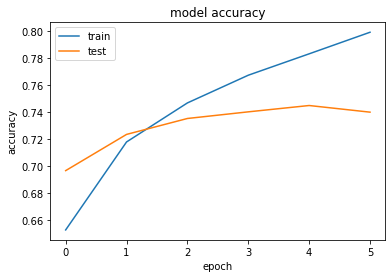

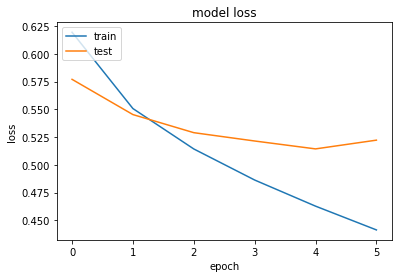

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# **RNN**

In [ ]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
print(model.summary())

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 40, 100)           7341900   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense_27 (Dense)            (None, 1)                 129       
                                                                 
Total params: 7,459,277
Trainable params: 117,377
Non-trainable params: 7,341,900
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/6
800/800 [==============================] - 85s 103ms/step - loss: 0.6574 - acc: 0.6093 - val_loss: 0.6383 - val_acc: 0.6360
Epoch 2/6
800/800 [==============================] - 85s 106ms/step - loss: 0.6344 - acc: 0.6383 - val_loss: 0.6244 - val_acc: 0.6481
Epoch 3/6
800/800 [==============================] - 86s 107ms/step - loss: 0.6176 - acc: 0.6537 - val_loss: 0.6138 - val_acc: 0.6589
Epoch 4/6
800/800 [==============================] - 82s 103ms/step - loss: 0.6020 - acc: 0.6687 - val_loss: 0.5986 - val_acc: 0.6740
Epoch 5/6
800/800 [==============================] - 83s 104ms/step - loss: 0.5846 - acc: 0.6842 - val_loss: 0.5843 - val_acc: 0.6857
Epoch 6/6
1000/1000 [==============================] - 18s 18ms/step - loss: 0.5702 - acc: 0.6999


In [ ]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.5701817870140076
Test Accuracy: 0.6999375224113464


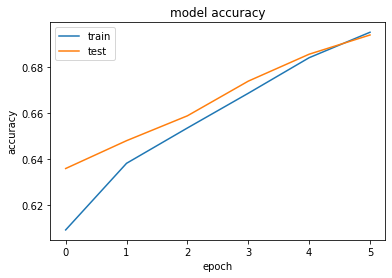

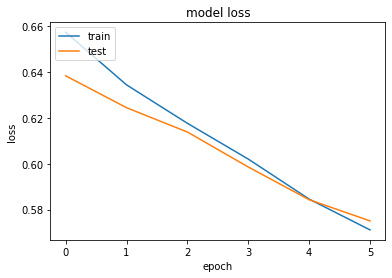

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()